# GAxOctagon Hackathon: Reddit Comment Analysis
### Danielle Medellin, Sally Huang, Stephen Burnett, Pierce Butler, Katherine Lough

## Import Libraries

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import re
from bs4 import BeautifulSoup   
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS as stopwords

## Import Data

In [237]:
# read data
events = pd.read_csv('../data/events_reddit.csv')

In [238]:
# show df 
events.head()

,author,body,created_utc,subreddit,permalink,query,timestamp
0,GrauGeist8888,WTF are you even asking for? It is self-evide...,1590182777,Coronavirus,/r/Coronavirus/comments/gnuq3s/only_73_of_peop...,measures,2020-05-22
1,Disaster_Area,I'm context it's quite obvious that I was sayi...,1590183249,Coronavirus,/r/Coronavirus/comments/go0p56/potus_has_legal...,measures,2020-05-22
2,IHeedNealing,Not at all my point or intent. Just a few week...,1590183477,Coronavirus,/r/Coronavirus/comments/gojqi1/daily_discussio...,measures,2020-05-22
3,Omnitraxus,&gt;One of your aunt's colleagues is a super s...,1590183560,Coronavirus,/r/Coronavirus/comments/go9exo/the_us_records_...,measures,2020-05-22
4,srelma,&gt;Were reporting something like 140k deaths ...,1590183767,Coronavirus,/r/Coronavirus/comments/goicek/the_death_toll_...,measures,2020-05-22


In [239]:
events.shape

(1600, 7)

We have 1600 comments with 7 features each. 

## Data Cleaning

In [240]:
events.dtypes

author         object
body           object
created_utc     int64
subreddit      object
permalink      object
query          object
timestamp      object
dtype: object

All datatypes are correct except the `timestamp`, which we must convert to datetime. 

In [241]:
events['timestamp'] = pd.to_datetime(events['timestamp'])

In [242]:
events.dtypes

author                 object
body                   object
created_utc             int64
subreddit              object
permalink              object
query                  object
timestamp      datetime64[ns]
dtype: object

In [243]:
events.isnull().sum()

author         0
body           0
created_utc    0
subreddit      0
permalink      0
query          0
timestamp      0
dtype: int64

There are no null values in this dataset. 

## Exploratory Data Analysis

We will look at the comments (`body`) from reddit posts to see what the most common words and phrases are. We can use Count Vectorizer to do this.

In [244]:
# words to be removed or added to `custom_stopwords` list 
remove = ['against','enough','only','no','not']
append = ['like','don','gt','https','www','scmp','com','x200b','2020', 'does','did','gstatic']

After iterating through this process a few times, some words were found to be unnecessary and thus were added to the stopwords list, such as words from links (`https`) and others were deemed necessary and removed from the stop words list, such as `not`, in order to get a better read on sentiment found within the Reddit comments.

In [245]:
# editing custom stopwords list from stopwords found in SKLearn
custom_stops = list(stopwords)
for word in remove:
    custom_stops.remove(word)
for word in append:
    custom_stops.append(word)

In [246]:
# stripping comments of punctuation and stop words
stripped_comments = []

for comment in events['body']:
    letters_only = re.sub("[^a-zA-Z]"," ", comment)
    words = letters_only.lower().split()
    meaningful_words = [w for w in words if w not in custom_stops] 
    new_body = " ".join(meaningful_words)
    stripped_comments.append(new_body)

events['stripped'] = stripped_comments

Using Natural Language Processing we stripped all comments of their non-alphanumeric characters and removed stop words. These stripped comments were added as an additional column to the data frame to easily reference if necessary. We also did not want to replace the original comments in case they were needed for reference as well. 

In [247]:
cvec = CountVectorizer(stop_words=custom_stops, ngram_range=(2,4))
X_text = events['body']
X_text = cvec.fit_transform(X_text)
X_text_df = pd.DataFrame(X_text.toarray(), columns = cvec.get_feature_names())

Each comment was put through a count vectorizer to determine the most frequently found words and phrases. A minimum n-gram of 2 was used in order to give more context to the comments. 

In [248]:
# find top 20 most common words/phrases 
top20words = X_text_df.sum().sort_values(ascending=False)[:20]

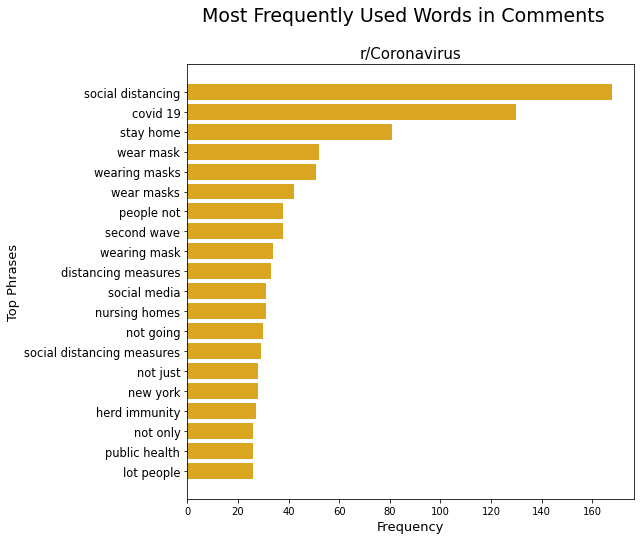

In [249]:
# create bar chart for all comments 
plt.figure(figsize=(8,8))
plt.barh(y=top20words.index[::-1],width=top20words[::-1],color='goldenrod')
plt.suptitle('Most Frequently Used Words in Comments',size=19)
plt.title('r/Coronavirus',size=15)
plt.xlabel('Frequency',size=13)
plt.ylabel('Top Phrases',size=13)
plt.yticks(size=11.5);

Many of the phrases on this graph are unsurprising such as `covid 19` and `social distancing`. There are multiple iterations of phrases pertaining to wearing masks. Some phrases are relevant to protocols put in place such as `social distancing measures`, `herd immunity`, and `public health`. Overall, this does not give us a clear picture as to how people are feeling towards COVID-19 or more specifically, how they are reacting to the possibility of attending events in the future. The phrase `stay home` is the second most occurring phrase, but even this can be misleading as a comment can say "I don't think I should _stay home_." 

In [250]:
# create function to get individual top 10s
def get_cvec(query):
    # instatiate count vec
    cvec = CountVectorizer(stop_words=custom_stops, ngram_range=(2,4))
    # find comments from specific query word
    comments = events.loc[events['query']==query,'body']
    # put comments through count vec
    comments = cvec.fit_transform(comments)
    # create df 
    df = pd.DataFrame(comments.toarray(), columns = cvec.get_feature_names())
    # isolate top 10 most common words/phrases 
    top_words = df.sum().sort_values(ascending=False)[:10]
    return top_words

The function above will take specific query words and find the top 10 most common words and phrases found in the comments that were pulled related to that query word. 

In [251]:
# obtaining top 10 for all 16 query words
unsafe_words = get_cvec('unsafe')
sports_words = get_cvec('sports')
concert_words = get_cvec('concert')
measures_words = get_cvec('measures')
event_words = get_cvec('event')
feel_words = get_cvec('feel')
social_words = get_cvec('social')
dangerous_words = get_cvec('dangerous')
game_words = get_cvec('game')
fan_words = get_cvec('fan')
danger_words = get_cvec('danger')
protocols_words = get_cvec('protocols')
safe_words = get_cvec('safe')
safety_words = get_cvec('safety')
concern_words = get_cvec('concern')
attend_words = get_cvec('attend')

In [263]:
# create bar chart of top 10 words 
def get_topwords_chart(topwords,query, color):
    plt.figure(figsize=(5,5))
    plt.barh(y=topwords.index[::-1],width=topwords[::-1],color=color)
    plt.suptitle(f'Most Frequently Used Words in Comments for Query: {query}',size=17)
    plt.title('r/Coronavirus',size=15)
    plt.xlabel('Frequency',size=13)
    plt.ylabel('Top Phrases',size=13)
    plt.yticks(size=11.5);

The above function will create a horizontal bar chart of the top 10 most commonly used phrases for each individual query word. 

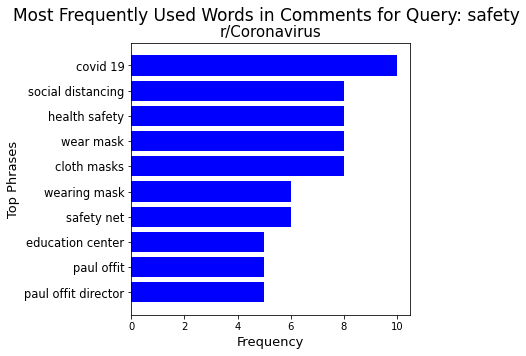

In [264]:
get_topwords_chart(safety_words, 'safety', 'blue')

Again, it is unsurprising that `covid 19` is at the top of this list, followed by `social distancing`. There are again, many phrases related to wearing a mask. An interesting addition to this chart is Paul Offit, who is a "pediatrician specializing in infectious diseases and an expert on vaccines, immunology, and virology." [Source](http://paul-offit.com/about/)

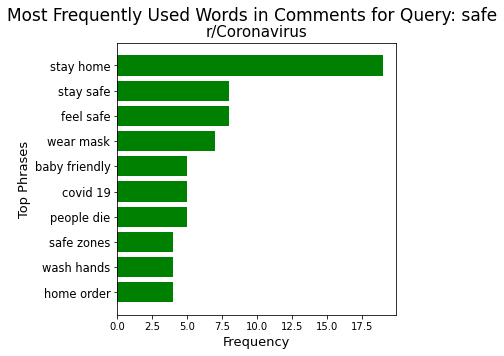

In [265]:
get_topwords_chart(safe_words, 'safe', 'green')

The number one phrases here for comments including the word `safe` is `stay home`, which as discussed above could be talked about in both a positive and negative way. 

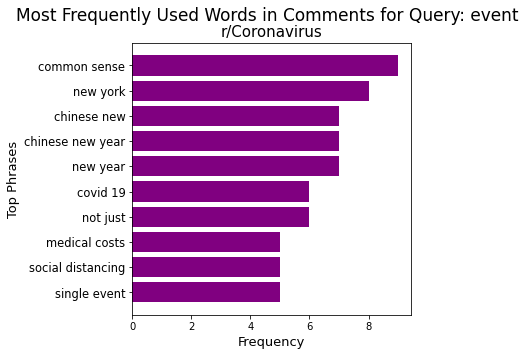

In [267]:
get_topwords_chart(event_words, 'event', 'purple')

For comments involving the word `event`, the phrase `common sense` is most common, which we found interesting. We are assuming users are adivising each other to use common sense when attending or considering going to events. 

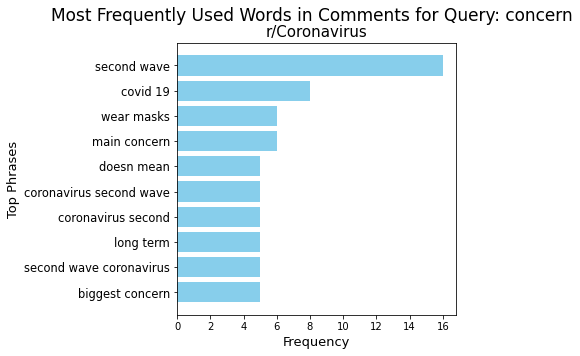

In [269]:
get_topwords_chart(concern_words, 'concern', 'skyblue')

When looking at comments with the word `concern`, there is a lot of talk about a `second wave` as well as `long term` (effects?) which just solidifies that it is important to be thinking about the future of events and what safety precautions should be taken in order to avoid or lessen a second wave of the virus. 

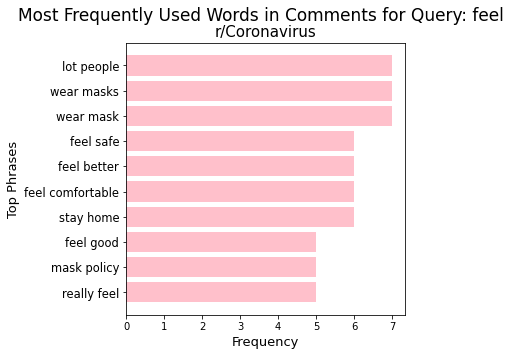

In [270]:
get_topwords_chart(feel_words, 'feel', 'pink')

In an effort to gauge opinion, we queried the word `feel`. Results from these comments are inconclusive, as phrases such as `feel safe` can be taken out of context. For example, "I do _feel safe_" or "I don't _feel safe_."

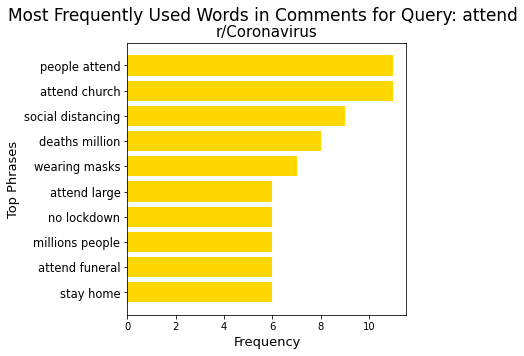

In [273]:
get_topwords_chart(attend_words, 'attend', 'gold')

When searching for comments with the word `attend` we seem to get more factual comments such as the amounts of people attending specific events. 

## Conclusions & Next Steps